In [1]:
import pandas as pd
import ipcalc
import parse_functions as pf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import user_agents as ua
from helpers import filter_other, autopct_format
import calendar

# Vorbereitung: Einlesen der Daten
- Für die Analsyse müssen die Daten des acces.log Datei eingelesen werden!

### Schwierigkeit
- Größe des Datensatzes: 10.365.152 Log Einträge (über 10 Milionen)
- keine eindeutiges Trennzeichen in den Daten vorhanden
- kein von Pandas vorgefertigter Import für Log Dateien

**So sehen die Anfragen aus:**
```
31.56.96.51 - - [22/Jan/2019:03:56:16 +0330] "GET /image/60844/productModel/200x200 HTTP/1.1" 200 5667 "https://www.zanbil.ir/m/filter/b113" "Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build/HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36" "-"

31.56.96.51 - - [22/Jan/2019:03:56:16 +0330] "GET /image/61474/productModel/200x200 HTTP/1.1" 200 5379 "https://www.zanbil.ir/m/filter/b113" "Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build/HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36" "-"
```

### Lösung
- Nutzung des Read_CSV Befehls angewandt auf die acces.log-Datei
- Anwendung möglich durch die Angabe des Seperators mitthilfe einer Regular Expression ```sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\]\s)'```
- Nach eindeutiger zuordnung des Trennzeichens können Daten eingelesen werden!

**Nachteil:** Die Ladezeit ist aufgrund der Größe des Datensatzes relativ lang (ca. 10-15 Minuten)

In [ ]:
# Source: https://mmas.github.io/read-apache-access-log-pandas
access_log = pd.read_csv(
    'data/access.log',
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\]\s)',
    engine='python',
    na_values='-',
    header=None,
    usecols=[0, 3, 4, 5, 6, 7, 8],
    names=['ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'],
    converters={'time': pf.parse_datetime,
                'request': pf.parse_str,
                'status': int,
                'size': int,
                'referer': pf.parse_str,
                'user_agent': pf.parse_str},
    on_bad_lines='warn')

access_log.head()


# Umwandlung in CSV Datei
- Nachdem Daten eingelesen wurden diese direkt als CSV-Datei "zwischenspeichern"

**Vorteil:** Verkürzt die Ladezeit auf ca. 3-4 Minuten
- CSV Datei kann genutzt werden um die Daten erneut einzulesen <br>
- Das Einladen über die strukturierte CSV Datei geht deutlich schneller als laden der Daten aus der acces.log Datei

In [ ]:
# Daten in einer CSV Datei speichern
filename = "data/acces_log.csv"
access_log.to_csv(filename)

# Daten aus CSV laden
- Die Daten aus der zuvor genrierten CSV Datei laden. 

**Wichtig:** Es muss zuvor die CSV Datei generiert werden, indem mindestens einmal die Daten aus der acces.log Datei eingelesen wurden!
- dieser Schritt wird also erst bei der mehrfachen Ausführung des Notebooks sinnvoll! 

In [2]:
# Daten aus CSV laden
filename = "data/acces_log.csv"
access_log = pd.read_csv(filename)

In [3]:
# Erzeuge eine Kopie der Daten als "Backup" 
access_log_backup = access_log.copy()
len(access_log_backup)

10365152

## Daten konvertieren & normalisieren
Die in der CSV hinterlegten Daten in die benötigten Datentypen überführen

- time: soll als Datum im Pandas Dataframe hinterlegt und entsprechend Normalisiert werden!

In [4]:
# Typen konvertieren
access_log['time'] = pd.to_datetime(access_log['time'])

# Daten normalisieren
access_log['time'] = access_log['time'].dt.tz_convert('UTC')

# Aufgabe 1: Beliebtestes Produkt

> Analysieren Sie welche Produkte beliebt sind. Entwickeln Sie dazu eine Definition eines beliebten Produktes. Stellen Sie die Ergebnisse anschaulich da.

## Definition

> Das Produkt mit dein meisten Aufrufen auf dem Webserver

## Ergebnis

> Das Product mit der ProductID 33968 wurde am häufigsten aufgerufen! Hierbei handelt es sich um das: Galaxy-J6-Plus-Dual-32GB


In [5]:
def extract_product_id(request):
  m = re.search(r"\s\/product\/(\d+)\/", str(request))
  if m:
    return m.group(1)
  return None

access_log['product_id'] = access_log['request'].map(extract_product_id)
access_log.head()

,Unnamed: 0,ip,time,request,status,size,referer,user_agent,product_id
0,0,54.36.149.41,2019-01-22 00:26:14+00:00,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,None
1,1,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,None
2,2,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,None
3,3,40.77.167.129,2019-01-22 00:26:17+00:00,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,None
4,4,91.99.72.15,2019-01-22 00:26:17+00:00,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,31893


764 x ID: 33953


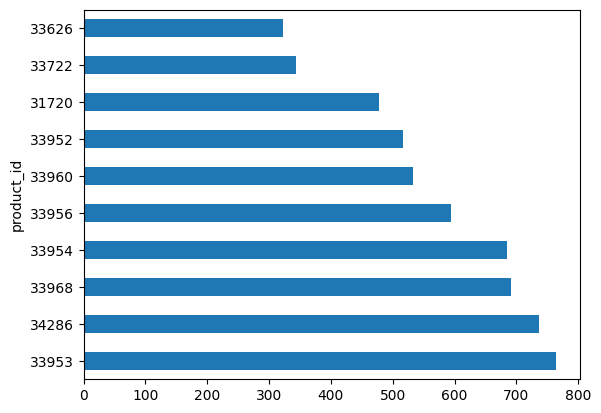

In [6]:
most_viewed_products = access_log.loc[access_log['product_id'] != None].value_counts(access_log['product_id'])
most_viewed_products = most_viewed_products[0:10]
most_viewed_products.plot(kind='barh')
most_viewed_product_id = most_viewed_products.keys()[0]
print(most_viewed_products[0], 'x', 'ID:', most_viewed_product_id)

# TODO: Display Product for Id

# Aufgabe 2

> Untersuchen Sie den Datensatz auf weitere Auffälligkeiten.


## Basisinformationen durch Pandas-Befehle
- Pandas bietet bereits vordefinierte Befehle um einfache Informationen über die Daten zu ermitteln
- Mit den Befehlen zu beginnen, hilft dabei die Daten ein erstes mal zu erkunden!
- Speziell bei numerrischen Daten erhält man bereits eine Reihe an spannenden statistischen Informationen
- Auch für Daten wie die des Logs, lohnt es sich kurz beide Befehle anzugucken!

### Befehl `.info()`
- Übersicht über die Spalten
- Angabe zu den Datentypen der Spalten

In [7]:
access_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10365152 entries, 0 to 10365151
Data columns (total 9 columns):
 #   Column      Dtype              
---  ------      -----              
 0   Unnamed: 0  int64              
 1   ip          object             
 2   time        datetime64[ns, UTC]
 3   request     object             
 4   status      int64              
 5   size        int64              
 6   referer     object             
 7   user_agent  object             
 8   product_id  object             
dtypes: datetime64[ns, UTC](1), int64(3), object(5)
memory usage: 711.7+ MB


### Befehl `.describe()`
- Anzahl der Einträge
- wie viele einzigartige Einträge
- höchste Zahl
- Durchschintt
- weitere statistische Angaben!

--> Statistische Basisinformationen <br>
--> Parameter `include = 'all'` notwendig, dass auch nicht numerische Daten in die Übersicht mit übernommen werden



In [8]:
access_log.describe(include = 'all')

,Unnamed: 0,ip,time,request,status,size,referer,user_agent,product_id
count,1.036515e+07,10365152,10365152,10365146,1.036515e+07,1.036515e+07,8718773,10350668,178110
unique,NaN,258606,NaN,894210,NaN,NaN,103236,28342,9652
top,NaN,66.249.66.194,NaN,GET /settings/logo HTTP/1.1,NaN,NaN,https://www.zanbil.ir/,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,33953
freq,NaN,353483,NaN,352037,NaN,NaN,494757,746572,764
mean,5.182576e+06,NaN,2019-01-24 09:32:56.248167680+00:00,NaN,2.101419e+02,1.243311e+04,NaN,NaN,NaN
min,0.000000e+00,NaN,2019-01-22 00:26:14+00:00,NaN,2.000000e+02,0.000000e+00,NaN,NaN,NaN
25%,2.591288e+06,NaN,2019-01-23 06:02:56+00:00,NaN,2.000000e+02,2.027000e+03,NaN,NaN,NaN
50%,5.182576e+06,NaN,2019-01-24 08:39:06+00:00,NaN,2.000000e+02,4.120000e+03,NaN,NaN,NaN
75%,7.773863e+06,NaN,2019-01-25 16:52:33+00:00,NaN,2.000000e+02,1.155100e+04,NaN,NaN,NaN
max,1.036515e+07,NaN,2019-01-26 16:59:13+00:00,NaN,5.040000e+02,1.249490e+06,NaN,NaN,NaN


# Daten Anzeigen
- Zum Anzeigen der Daten können unterschiedliche Methoden genutzt werden
- Anzeigen durch Methoden: ``` .head(x) | .tail(x) ``` gibt die ersten / letzten x Zeilen aus
- indizierter Zugriff wie aus Python bekannt ```acces_log[10000:10200]```

In [9]:
access_log.head(5)

,Unnamed: 0,ip,time,request,status,size,referer,user_agent,product_id
0,0,54.36.149.41,2019-01-22 00:26:14+00:00,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,None
1,1,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,None
2,2,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,None
3,3,40.77.167.129,2019-01-22 00:26:17+00:00,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,None
4,4,91.99.72.15,2019-01-22 00:26:17+00:00,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,31893


In [10]:
access_log[10000:10200]

,Unnamed: 0,ip,time,request,status,size,referer,user_agent,product_id
10000,10000,37.129.232.66,2019-01-22 01:06:57+00:00,GET /static/images/guarantees/support.png HTTP...,200,6454,https://www.zanbil.ir/m/filter/b785,Mozilla/5.0 (Linux; Android 7.0; RNE-L21 Build...,None
10001,10001,37.129.232.66,2019-01-22 01:06:57+00:00,GET /static/images/guarantees/fastDelivery.png...,200,7713,https://www.zanbil.ir/m/filter/b785,Mozilla/5.0 (Linux; Android 7.0; RNE-L21 Build...,None
10002,10002,37.129.232.66,2019-01-22 01:06:57+00:00,GET /static/css/font/wyekan/font.woff HTTP/1.1,200,28536,https://www.zanbil.ir/m/filter/b785,Mozilla/5.0 (Linux; Android 7.0; RNE-L21 Build...,None
10003,10003,66.249.66.194,2019-01-22 01:06:57+00:00,GET /m/filter/p11905%2Cb573%2Cb546%2Cb609%2Cst...,302,0,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,None
10004,10004,93.110.220.181,2019-01-22 01:06:57+00:00,GET /product/28204/56978/%D9%87%D9%88%D8%AF-%D...,200,43481,"https://www.zanbil.ir/filter/p2597,rf1660000,r...",Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,28204
...,...,...,...,...,...,...,...,...,...
10195,10195,85.239.198.13,2019-01-22 01:07:40+00:00,GET /image/33888?name=model-b2048u-1-.jpg&wh=2...,200,3975,NaN,Dalvik/1.6.0 (Linux; U; Android 4.2.2; MediaPa...,None
10196,10196,157.55.39.245,2019-01-22 01:07:41+00:00,GET /product/17516?model=33959 HTTP/1.1,200,41064,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,None
10197,10197,91.99.72.15,2019-01-22 01:07:41+00:00,GET /product/8248/10330/%DB%8C%D8%AE%DA%86%D8%...,200,41823,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,8248
10198,10198,23.101.169.3,2019-01-22 01:07:41+00:00,GET /static/images/icons/btn-search.png HTTP/1.1,200,393,https://www.zanbil.ir/product/31011/%DA%AF%D9%...,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,None


# Einfache Analyse der Anzahl einzelner Features:
- Zählen der Features durch ```.value_counts("feature")``` <br>
--> ermitteln welche IP Adresse die meisten Anfragen stellt <br>
--> Welches Produkt wurde am meisten angefragt (Aufgabe 1)

In [11]:
# IP-Adressen mit den meisten Aufrufen 
access_log.value_counts("ip").head()

ip
66.249.66.194      353483
66.249.66.91       314522
151.239.241.163     92475
66.249.66.92        88332
91.99.30.32         45979
Name: count, dtype: int64

# Datenergänzung / Datenaufbereitung zur Analyse

### Timestamps

- Zur Analyse des Timestamps werden einzelne Spalten für Wochentag (numerisch), Stunde und Datum erstellt
- Die neu erstellten Features können für Untersuchungen zu den Aufrufe nach Tageszeit / Tagen verwendet werden

In [12]:
access_log['date'] = access_log['time'].dt.date
access_log['weekday_n'] = access_log['time'].dt.weekday
access_log['weekday'] = access_log['weekday_n'].map(lambda wd: calendar.day_name[wd])
access_log['hour'] = access_log['time'].dt.hour

access_log.head()

,Unnamed: 0,ip,time,request,status,size,referer,user_agent,product_id,date,weekday_n,weekday,hour
0,0,54.36.149.41,2019-01-22 00:26:14+00:00,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,None,2019-01-22,1,Tuesday,0
1,1,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,None,2019-01-22,1,Tuesday,0
2,2,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,None,2019-01-22,1,Tuesday,0
3,3,40.77.167.129,2019-01-22 00:26:17+00:00,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,None,2019-01-22,1,Tuesday,0
4,4,91.99.72.15,2019-01-22 00:26:17+00:00,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,31893,2019-01-22,1,Tuesday,0


# Analyse der herausgearbeiteten Timestamp Eigenschaften 
- Analyse der Aufrufe je Tag
- Analyse der Aufrufe je Stunden

Darstellung beider Daten als Balkendiagramm

date
2019-01-22    2333977
2019-01-23    2326694
2019-01-26    1986456
2019-01-24    1896255
2019-01-25    1821770
Name: count, dtype: int64


<Axes: xlabel='date'>

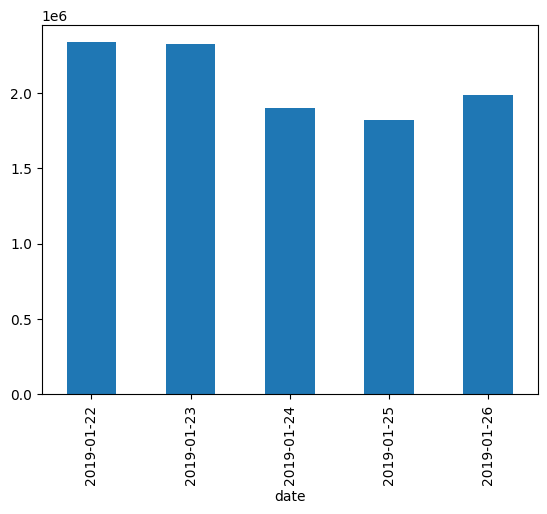

In [13]:
# Analyse der Tage (Zugriffstage)
days_count = access_log.value_counts('date')
print(days_count)
days_count.sort_index().plot(kind='bar')

# Ausertung Tagesanzahl
- Die Log-Datei enthält Informationen zu 5 Tagen
- Die ersten beiden Tage haben eine leicht höhere Anzahl an Anfragen, ansonsten aber eine relativ gleiche Verteilung der Last über alle Tage

hour
8     729525
9     728079
10    714435
7     707433
11    671300
Name: count, dtype: int64


<Axes: xlabel='hour'>

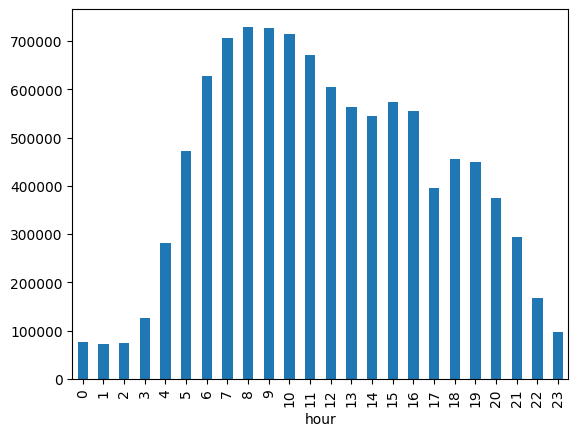

In [14]:
# Analyse der Stunden (Zugriffszeiten)
hours_count = access_log.value_counts('hour')
print(hours_count.head())
hours_count.sort_index().plot(kind='bar')

# Auswertung Stundenanalyse (Zugriffszeiten)
- Klares Tief in der Nacht zu erkennen
- Morgens ab 5 Uhr steigt die Anzahl an Aufrufen rapide
- Hochpunkt ist zwischen 8:00 und 9;00 Uhr morgens
- Über den Nachmittag zum Abend hin sinken die Aufrufe wieder deutlich

## Heatmap Tageszeit
- Alternative visualisierung der Tageszeiten

Text(0.5, 3.722222222222216, 'Uhrzeit')

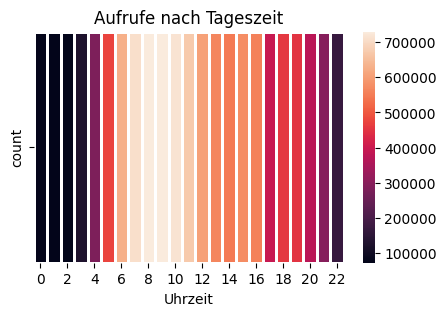

In [15]:
daytime_access = access_log.groupby(['hour']).size().to_frame(name = 'count').reset_index()

fig, ax = plt.subplots(1, 1, figsize = (5, 3))
df_wide = daytime_access.pivot_table(columns='hour', values='count', aggfunc=lambda x:x)
heatmap = sns.heatmap(df_wide, linewidths=1.0,ax=ax)

ax.set_xlim(0, 23)
ax.set_ylim(0, 1)

heatmap.set_title('Aufrufe nach Tageszeit')
heatmap.set_xlabel('Uhrzeit')


Text(33.22222222222222, 0.5, 'Wochentag')

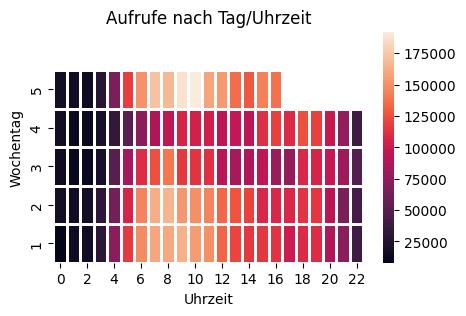

In [16]:
daytime_access = access_log.groupby(['weekday_n', 'hour']).size().to_frame(name = 'count').reset_index()

fig, ax = plt.subplots(1, 1, figsize = (5, 3))
df_wide = daytime_access.pivot_table(index='weekday_n',columns='hour',values='count', aggfunc=lambda x:x)
heatmap = sns.heatmap(df_wide, linewidths=1.0,ax=ax)

ax.set_xlim(0, 23)
ax.set_ylim(0, 6)
# ax.set_yticks(range(0, 7), ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So'])

heatmap.set_title('Aufrufe nach Tag/Uhrzeit')
heatmap.set_xlabel('Uhrzeit')
heatmap.set_ylabel('Wochentag')

# 1 => Dienstag


## Request Methods
Herausarbeiten welche unterschiedlichen Requests an den Server gestellt wurden

Die folgenden Request Methoden gibt es:  
`GET`, `HEAD`, `POST`, `PUT`, `DELETE`, `CONNECT`, `OPTIONS`, `TRACE` und `PATCH`

Hierzu wird auf alle `Method` Einträge eine von uns definierte Extraktionsmethode `extract_method()` ausgeführt <br>
--> Wähle Strings die mit Großbuchstaben beginnen und alle zugehörigen Großbuchstaben. ToDo: prüfen!

In [17]:
def extract_method(request):
  "Method to extract the HTTP-Method for a Request"
  m = re.match(r'^[A-Z]+', str(request))
  if m:
    return m.group()
  return None

access_log['method'] = access_log['request'].map(extract_method)
access_log.head()

,Unnamed: 0,ip,time,request,status,size,referer,user_agent,product_id,date,weekday_n,weekday,hour,method
0,0,54.36.149.41,2019-01-22 00:26:14+00:00,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,None,2019-01-22,1,Tuesday,0,GET
1,1,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,None,2019-01-22,1,Tuesday,0,GET
2,2,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,None,2019-01-22,1,Tuesday,0,GET
3,3,40.77.167.129,2019-01-22 00:26:17+00:00,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,None,2019-01-22,1,Tuesday,0,GET
4,4,91.99.72.15,2019-01-22 00:26:17+00:00,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,31893,2019-01-22,1,Tuesday,0,GET


method
GET         10190005
POST          139155
HEAD           34501
OPTIONS         1424
CONNECT           10
G                  6
E                  4
PROPFIND           3
Name: count, dtype: int64
10365108


<Axes: title={'center': 'Request Methods'}, ylabel='Method'>

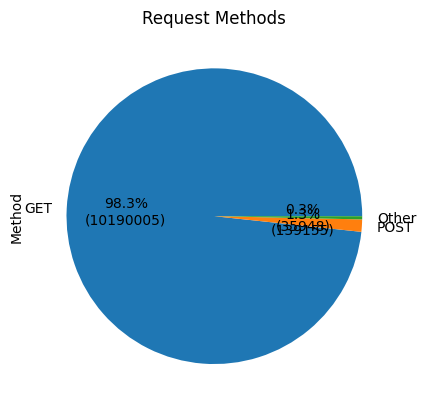

In [18]:
method_counts = access_log.loc[access_log['method'] != None]['method'].value_counts()

# Ausgabe der Methods
print(method_counts)

# Plot
method_counts_other = filter_other(method_counts, 0.005)
method_counts_other.plot(kind='pie', title='Request Methods', ylabel='Method', autopct=autopct_format(method_counts_other))

<Axes: title={'center': 'Request Methods'}, xlabel='method', ylabel='Method'>

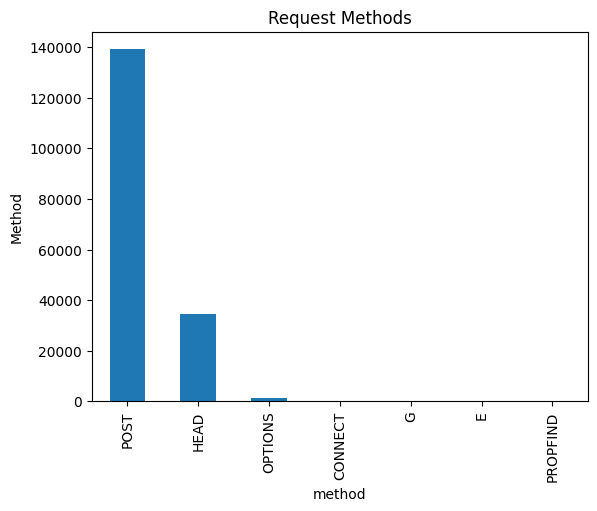

In [19]:
# ToDo: prüfen / absprechen --> ggf. auch noch Grafik in der die Get Requests raus sind -> zeigt anderes Besser -> (F) bringt nicht viel neues
method_counts_without_get = method_counts.drop(labels = 'GET')
method_counts_without_get.plot(kind='bar', title='Request Methods', ylabel='Method')

# Auswertung Request Methoden

- Sehr hohe Anzahl von Get Requests 98.3%
- Es existieren aber auch andere Reqeust
- 1.3% Post Requests
- Weitere Requests: HEAD; OPTIONS; CONNECT; G; E; PROPFIND

**ToDo:** Herausfinden was diese Reqeusts tun?

In [20]:
access_log.loc[access_log['method'] == 'POST'].head()

,Unnamed: 0,ip,time,request,status,size,referer,user_agent,product_id,date,weekday_n,weekday,hour,method
51,51,5.78.198.52,2019-01-22 00:26:26+00:00,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...,None,2019-01-22,1,Tuesday,0,POST
55,55,5.78.198.52,2019-01-22 00:26:27+00:00,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...,None,2019-01-22,1,Tuesday,0,POST
59,59,5.78.198.52,2019-01-22 00:26:28+00:00,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...,None,2019-01-22,1,Tuesday,0,POST
62,62,5.78.198.52,2019-01-22 00:26:29+00:00,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...,None,2019-01-22,1,Tuesday,0,POST
77,77,5.78.198.52,2019-01-22 00:26:30+00:00,POST /m/updateVariation?__amp_source_origin=ht...,200,394,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...,None,2019-01-22,1,Tuesday,0,POST


## User Agents, Browser & OS

In [21]:
agents = access_log['user_agent'].map(lambda agent: ua.parse(str(agent)))
access_log['browser_family'] = agents.map(lambda agent: agent.browser.family)
access_log['os_family'] = agents.map(lambda agent: agent.os.family)
access_log['device_family'] = agents.map(lambda agent: agent.device.family)
access_log['device_brand'] = agents.map(lambda agent: agent.device.brand)
access_log['device_model'] = agents.map(lambda agent: agent.device.model)
access_log['is_mobile'] = agents.map(lambda agent: agent.is_mobile)
access_log['is_pc'] = agents.map(lambda agent: agent.is_pc)
access_log['is_bot'] = agents.map(lambda agent: agent.is_bot)

access_log.head()

In [ ]:
browser_family_counts = access_log['browser_family'].value_counts()

browser_family_counts = filter_other(browser_family_counts)

browser_family_counts.plot(kind='pie', title='Browsers', ylabel='Browser', autopct=autopct_format(browser_family_counts))

In [ ]:
os_family_counts = access_log['os_family'].value_counts()

os_family_counts = filter_other(os_family_counts)

os_family_counts.plot(kind='pie', title='OS', ylabel='OS', autopct=autopct_format(os_family_counts))

In [ ]:
bot_counts = access_log['is_bot'].value_counts()

bot_counts.plot(kind='pie', title='Bots', ylabel='Bots', autopct=autopct_format(bot_counts))

### Reevaluation von Aufgabe 1

Ändert sich das Ergebnis, wenn wir Bots ausschließen?

In [ ]:
# Ergebnis von vorher
print('Ergebnis von vorher')
print(most_viewed_products[0], most_viewed_products.keys()[0])

print()

# Neues Ergebnis
print('Neues Ergebnis')
most_viewed_products2 = access_log.loc[access_log['is_bot'] != True].loc[access_log['request'].str.contains(r'^GET /product/\d+', na=False)].value_counts(access_log['request'])
print(most_viewed_products2[0], most_viewed_products2.keys()[0])

print()

# Evaluate
if most_viewed_products.keys()[0] == most_viewed_products2.keys()[0]:
    print('Gleiches Ergebnis')
else:
    print('Ergebnis verändert')
print('Differenz:', most_viewed_products[0] - most_viewed_products2[0], 'Bot-Aufrufe')

## Fehler

In [ ]:
status_counts = access_log['status'].value_counts()

status_counts = filter_other(status_counts, 0.01)

status_counts.plot(kind='pie', title='Status', ylabel='Status Code', autopct=autopct_format(status_counts))

In [ ]:
error_counts = access_log['status'].map(lambda status: status >= 400).value_counts()

error_counts.plot(kind='pie', title='Failed requests', ylabel='Error?', autopct=autopct_format(error_counts))

In [ ]:
error_logs = access_log.loc[access_log['status'] >= 400]

error_code_counts = error_logs['status'].value_counts()

error_code_counts = filter_other(error_code_counts, 0.01)

error_code_counts.plot(kind='pie', title='Error', ylabel='Error Code', autopct=autopct_format(error_code_counts))

In [ ]:
error_logs = access_log.loc[access_log['status'] != 200]
error_logs.head()

# Korrelationsanalyse der Daten
Im folgenden wird eine Korrelationsanalyse auf den Daten ausgeführt um zu prüfen, ob einzelne Features miteinander korrelieren.

- **Anmerkung:** Aktuell liegen kaum Numerische Daten vor! -> Korrelation jedoch für numerische Daten zu berechnen
- **Vorgehen:** Die nicht numerischen Daten die mit untersucht werden sollen in numerische Daten umwandeln.

### Begründung Korrelationsanalyse

- Untersuchung auf weitere Datenzusammenhänge die vorliegen, aber noch nicht bekannt sind.
- **Beispiel:** Gibt es einen Zusammenhang zwischen der Tageszeit und Post Reqeusts?

In [ ]:
# Korrelationen auf den Daten ohne Ergänzung
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(access_log.corr(numeric_only=True), annot=True, cmap="PuOr", fmt=".1f", vmin=-1, vmax=1)

# Ergänzung um weitere Features (Nummerische Umwandlung)
- Damit andere Features integriert werden können müssen sie entsprechend umgewandelt werden können

### Vorgehen:

- ```pd.get_dummies()``` Methode um aus einem Feature entsprechend mehrere Numerische Spalten zu erzeugen
- Jeder Eintrag des Features erhällt eine eigene Spalte, in der das entsprechende Feature mit ```true``` und ```false``` gekennzeichnet ist.

In [ ]:
# Ergänzen um die Dummies Einträge für Method
methods_numeric = pd.get_dummies(access_log['method'])
methods_numeric

In [ ]:
# Anwendung der Dummie Einträge auf unseren Datensatz 
methods_numeric = methods_numeric.drop(['CONNECT','E','G','OPTIONS','PROPFIND'], axis=1)

access_log = access_log.join(methods_numeric)
access_log.head()

In [ ]:
# Erneute Korrelationsanalyse
sns.heatmap(access_log.corr(numeric_only=True), annot=True, cmap="PuOr", fmt=".1f", vmin=-1, vmax=1)

In [ ]:
# Analyse der Korrelationen mit Product ID | TODo: wenn das gewünscht ist müssen wir die Product ID als Integer speichern!
access_log_copy = access_log.copy()

mask = access_log_copy["product_id"] != None # ToDo: warum erkennt er das none nicht?
mask.value_counts()
access_log_copy = access_log_copy[mask]
access_log_copy

In [ ]:
type(access_log["product_id"][4])

## Open Ideas

- [x] Nutzung im Tagesverlauf (UTC) (Flo)
  * Wochentage analysieren
- [ ] IP auf Locations mappen
- [ ] Nutzung nach Tageszeit (korrigiert nach Location / Timezone based on IP)
- [x] Requests außer `GET`? (Flo)
- [x] Aufrufe mit Status `!= 200` => Fehler
- [ ] Referers analysieren
- [ ] Nach Nutzer und Pfaden gruppieren und zählen => Entscheidungsfreudigkeit der Nutzer
- [x] Korrelation untersuchen (Tom)
- [ ] Sessions von Nutzern zählen / schätzen
- [x] Browser analysieren (Flo)